In [1]:
import sys
sys.path.append('/Users/raban/Documents/PHD/Teaching/Patrick (reading out equations)/nn_physical_concepts')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scinet import *
import scinet.ed_collision as edc

### Plotting functions

In [2]:
 # Plot the activation of the latent neuron against the total angular momentum. The input data is of the same form as the training/validation data and the corresponding states
def plot_state_neuron_wrt_angular_momentum(nn,data,data_states):
    total_angular_momentum=edc.total_ang_mom(data_states[:,2],data_states[:,5])
    out = nn.run(data, nn.mu, additional_params={})
    f=plt.figure(figsize=(3.4, 2.1))
    blue_color = '#000cff'
    plt.scatter(total_angular_momentum,out.flatten(),1,color=blue_color)
    plt.xlabel('Total angular momentum [kg$\,$m$^2$/s]')
    plt.ylabel('Activation latent neuron')
    return f

# Plot the 2D physical setting for the angular momentum conservation example. The data/data_states is of the same shape as the training or validation data/data_states.
# The situation at the ith data sample is then plotted.
def plot_physical_setting(nn,index,data,data_states):
    vx_in=data_states[index,2]
    w_in=data_states[index,5]
    vx_out=data_states[index,6]
    input1=data[0][index]
    input2=data[1][index]
    # Before the collision
    input1=input1.flatten()
    part=input1.size / 6
    x_in_free=input1[0:part]
    y_in_free = input1[part:2*part]
    x_in_rot = input1[3*part:4*part]
    y_in_rot = input1[4 *part:5*part]
    # After collision
    input2 = input2.flatten()
    part = (input2.size-1)/3
    x_out_free = input2[0:part]
    y_out_free = input2[part:2*part]
    # Correct position of rotating particle
    times=np.linspace(0,4, num=4)
    x_out_rot_correct=[]
    y_out_rot_correct=[]
    for i in range(len(times)):
        x_out_rot_correct.append(edc.generate_output(times[i], vx_out, vx_in, w_in)[0])
        y_out_rot_correct.append(edc.generate_output(times[i], vx_out, vx_in, w_in)[1])
    # Predicted  position of rotating particle
    x_out_rot_pred = []
    y_out_rot_pred = []
    data_modified=[data[0].copy(),data[1].copy(),data[2].copy()]
    for i in range(len(times)):
        data_modified[1][index][-1]=times[i]
        output = nn.run(data_modified,nn.output)[index]
        x_out_rot_pred.append(output[0])
        y_out_rot_pred.append(output[1])
    # Create plot
    blue_color = '#000cff'
    orange_color = '#ff7700'
    f = plt.figure()
    ax = plt.subplot(111)
    plt.scatter(x_in_free, y_in_free,15, color=blue_color, marker='o',label='Incoming free particle')
    plt.scatter(x_in_rot, y_in_rot,15, color=orange_color,marker='o', label='Incoming rotating particle')
    plt.scatter(x_out_free,y_out_free,15, color=blue_color, marker='s', label='Outgoing free particle')
    plt.scatter(x_out_rot_correct, y_out_rot_correct,50, color=orange_color, marker='s', label='Outgoing rotating particle')
    plt.scatter(x_out_rot_pred, y_out_rot_pred, color='k', marker='x', label='Pedictions')
    # Shrink current axis by 40%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.6, box.height])
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Collision experiment and predictions of the NN')
    plt.axis([-4,4 , -2, 6])
    return f

## Load pre-trained model

### Parameters
- `latent_size: 1` 
- `input_size: 30`
- `input2_size: 16`
- `output_size: 2`
- `encoder_num_units: [150, 100]`
- `decoder_num_units: [100, 150]`
- other parameters: default values

### Data
-  The masses and the radius of the rotating particle are fixed. The others are varied under the restriction that the two particle will collide at (0,1). See the data generation file ``ed_collision`` for more details. 
- N_in1 = 5 time steps for observation input, N_inp2 = 5 time steps for question input
- training data: 490000 samples
- validation data: 10000 samples

### Training
- `epoch_num: 100`, `batch_size: 500`, `learning_rate: 5e-4`, `beta: 0.`
- `epoch_num: 50`, `batch_size: 500`, `learning_rate: 1e-4`, `beta: 0.`

In [2]:
net = nn.Network.from_saved('collision')

{'decoder_num_units': [100, 150], 'input2_size': 16, 'tot_epochs': 150, 'latent_size': 1, 'output_size': 2, 'encoder_num_units': [150, 100], 'input_size': 30, 'load_file': 'collision', 'name': 'collision'}
INFO:tensorflow:Restoring parameters from /Users/raban/Documents/PHD/Teaching/Patrick (reading out equations)/nn_physical_concepts/tf_save/collision.ckpt
Loaded network from file collision


In [3]:
vd, vs, _ = edc.create_data(1, 5, 5);

## Plots

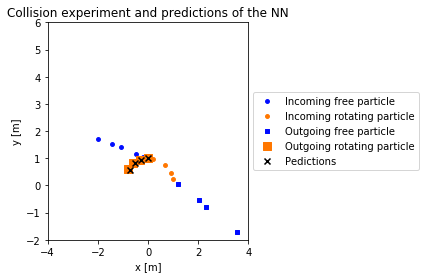

In [5]:
fig1 = plot_physical_setting(net, 0, vd, vs)

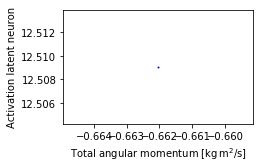

In [6]:
fig2 = plot_state_neuron_wrt_angular_momentum(net, vd, vs)

## Calculate reconstruction loss

In [7]:
np.sqrt(net.run(vd, net.recon_loss))

0.09176538

## Calculate derivative of latent neuron with respect to the input

In [6]:
# Find the derivatives of the latent neuron with respect to all input variables
net.get_latent_derivatives(vd)

array([-2.202099  , -1.9994277 , -1.6728481 , -1.5120203 , -1.480278  ,
        0.2042953 , -0.08662469, -0.22841597, -0.177281  , -0.3482374 ,
       -0.55595666,  2.7355866 ,  2.3542287 ,  2.057496  ,  2.0786693 ,
        2.9937158 ,  1.2596759 ,  0.21084067,  0.06872684,  1.186117  ,
       -0.33829752,  0.91044104,  1.333923  , -0.07992363, -0.8145194 ,
       -0.76594967, -4.9044914 , -3.1775672 ,  0.5338595 ,  4.301209  ],
      dtype=float32)

In [8]:
# To check if the derivative it calculated properly, we compare it with the differential quotient 
# ToDo: Remove this in the final version.
out=[]
for direction in range(30):
    l1 = net.run(vd, net.mu, additional_params={})
    eps=10.**(-4)
    vd[0][0][direction]+=eps
    l2 = net.run(vd, net.mu, additional_params={})
    #restore vd
    vd[0][0][direction]-=eps
    #Differential quotient
    out.append(((l2-l1)/eps)[0][0])
out

[-2.1970272,
 -1.9931793,
 -1.66893,
 -1.5127659,
 -1.4674664,
 0.19669533,
 -0.08583069,
 -0.22172928,
 -0.16450882,
 -0.34332275,
 -0.5543232,
 2.7394295,
 2.349615,
 2.053976,
 2.0825863,
 2.9981136,
 1.2683868,
 0.20980835,
 0.07510185,
 1.1873245,
 -0.33259392,
 0.91552734,
 1.3375282,
 -0.07033348,
 -0.81181526,
 -0.76055527,
 -4.900694,
 -3.1733513,
 0.5412102,
 4.3058395]

In [16]:
 # Plot the activation of the latent neuron against an an epsilon neighbourhood of the input variable with number
 # "input_neuron_number" at a point given by a data_sample (may help to gain intuition)
 # ToDo: Clear up or remove in the final version   
def plot_state_neuron_wrt_input_variable(nn,data_sample,input_neuron_number):
    eps_list = []
    out = []
    for eps in np.arange(-0.2,0.2,0.001):
        eps_list.append(eps)
        data_sample[0][0][input_neuron_number]+=eps
        latent_activation = nn.run(data_sample, nn.mu, additional_params={})[0][0]
        out.append(latent_activation)
        data_sample[0][0][input_neuron_number]-=eps
    f=plt.figure(figsize=(3.4, 2.1))
    blue_color = '#000cff'
    plt.scatter(eps_list,out,1,color=blue_color)
    plt.xlabel('Distance from entry in the data sample')
    plt.ylabel('Activation latent neuron')
    return f

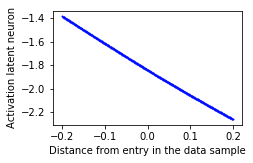

In [17]:
f=plot_state_neuron_wrt_input_variable(net,vd,0)